In [36]:
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성.
데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴

In [37]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [24]:
index_to_word = {index:word for word, index in word_to_index.items()}
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [30]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[1912])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(X_train[0], index_to_word))
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

<BOS>
1915
레딧
습니다 설명 <UNK> <UNK> 네요 공포 ! 안 잠
(146182, 41)


In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)
model_history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 234,369
Trainable params: 234,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
3631/3631 [==============================] - 44s 6ms/step - loss: 0.6689 - accuracy: 0.5620 - val_loss: 0.6956 - val_accuracy: 0.5034

Epoch 00001: saving model to best_model.h5
Epoch 2/20
3631/3631 [==============================] - 20s 6ms/step - loss: 0.5761 - accuracy: 0.6641 - val_loss: 0.3824 - val_accuracy: 0.8352

Epoch 00002: saving model to best_model.h5

## Visualization

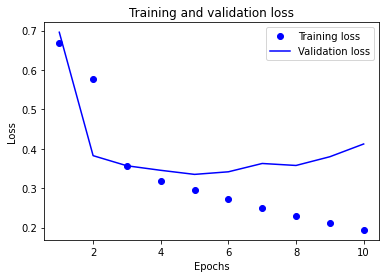

In [38]:
LSTM_history_dict = model_history.history
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

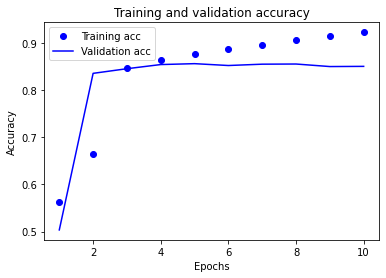

In [39]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()